# Vehicle Detection and Tracking

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import os
import time

%matplotlib inline

## Load Data

In [2]:
test_images = [mpimg.imread('test_images/' + file) for file in os.listdir('test_images')]

In [41]:
# These are all 64x64 png images

vehicles_folders = ['data/vehicles/GTI_Far/', 'data/vehicles/GTI_Left/', 'data/vehicles/GTI_MiddleClose/', 'data/vehicles/GTI_Right/', 'data/vehicles/KITTI_extracted/']
# vehicles_folders = ['data/vehicles/KITTI_extracted/']
nonvehicles_folders = ['data/non-vehicles/Extras/', 'data/non-vehicles/GTI/']
# nonvehicles_folders = ['data/non-vehicles/GTI/']


udacity_vehicles = [mpimg.imread(folder + file) for folder in vehicles_folders for file in os.listdir(folder)]
udacity_non_vehicles = [mpimg.imread(folder + file) for folder in nonvehicles_folders for file in os.listdir(folder)]

udacity_features_raw = np.concatenate((udacity_vehicles, udacity_non_vehicles))

## Train SVM

In [58]:
def feature_pipeline(image, feature_vector=True):
    cells_per_block = (4,4)
    pixels_per_cell = (16,16)
    orientations= 9
    
    image = cv2.resize(image, (64, 64))
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ch0 = yuv[:,:,0]
    ch1 = hsv[:,:,1]
    ch2 = hsv[:,:,0]
    ch0_features = hog(ch0, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector)
    ch1_features = hog(ch1, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector)
    ch2_features = hog(ch2, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector)
    hog_features = np.concatenate((ch0_features, ch1_features, ch2_features))
    
    return hog_features

In [59]:
start = time.time()

udacity_features = [feature_pipeline(image) for image in udacity_features_raw]
udacity_labels = np.concatenate((np.ones(len(udacity_vehicles)), np.zeros(len(udacity_non_vehicles))))

scaler = StandardScaler()
scaler.fit(udacity_features)
udacity_features_scaled = scaler.transform(udacity_features)

end = time.time()

print('Runtime (s):', end - start)

Runtime (s): 32.44800686836243


In [60]:
start = time.time()

split_index = int(len(udacity_features_scaled) * .8)
X_train = udacity_features_scaled[0: split_index]
X_test = udacity_features_scaled[split_index:]
y_train = udacity_labels[0:split_index]
y_test = udacity_labels[split_index:]
# X_train, X_test, y_train, y_test = train_test_split(udacity_features_scaled, udacity_labels)

svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)

end = time.time()

print('Test Accuracy: ', accuracy)
print('Model runtime (s):', end - start)

Test Accuracy:  0.824887387387
Model runtime (s): 1.2292654514312744


## Pipeline

In [61]:
def pipeline(image):
    image = np.copy(image)
    roi = image[360:]
    windows = sliding_windows(roi.shape)
    window_images = [roi[y1:y2,x1:x2][np.newaxis, ...] for x1,y1,x2,y2 in windows]
    window_images = np.concatenate(window_images, axis=0)
    features = [feature_pipeline(window_image)[np.newaxis,...] for window_image in window_images]
    features = np.concatenate(features)
    
    features_scaled = scaler.transform(features)
    pred = svc.predict(features_scaled)    
    
    for i in range(len(windows)):
        window = windows[i]
        if pred[i] == 1:
            cv2.rectangle(image, (window[0], window[1] + 360), (window[2], window[3] + 360), (0, 0, 255), 5)
    return image

def sliding_windows(shape):
    window_size = 64
    step = 32
    return [(x,y, x+window_size, y+window_size) for y in range(0, shape[0] - window_size, step) for x in range(0, shape[1] - window_size, step)]

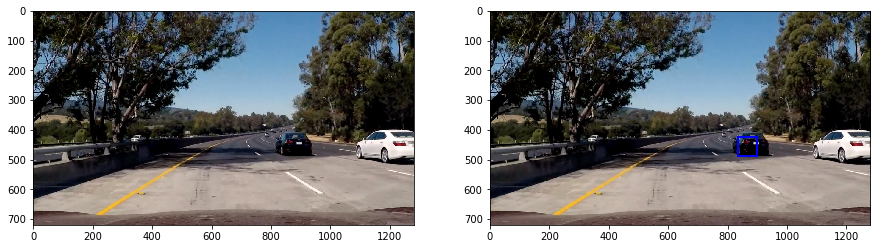

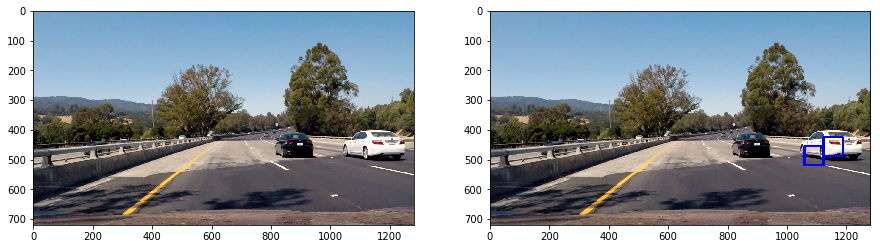

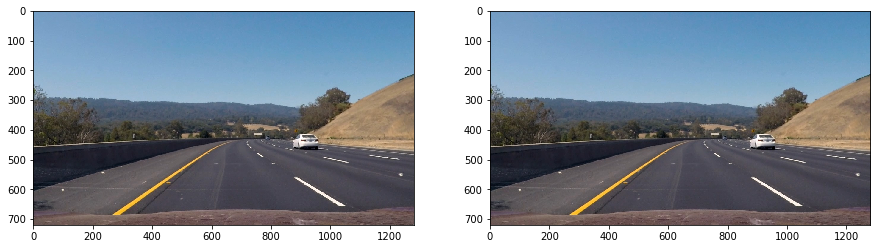

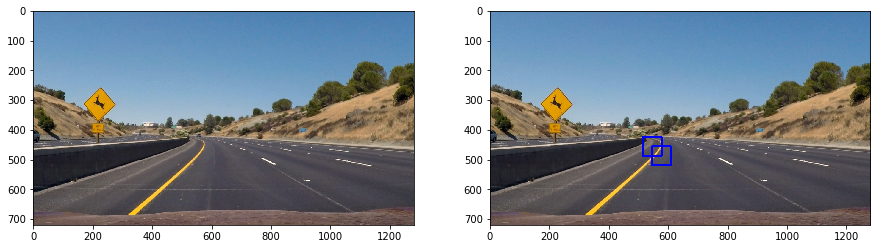

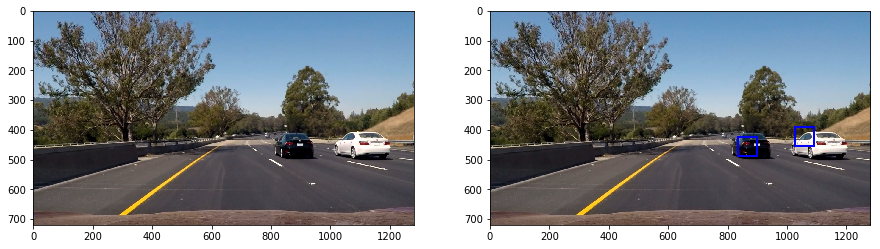

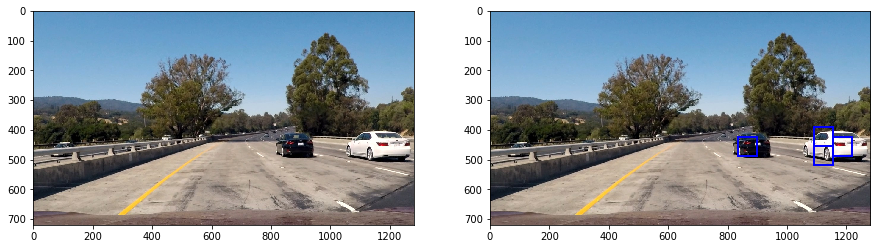

In [62]:
for image in test_images:
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(pipeline(image), cmap='gray')